# Random Forest Project Tutorial

**Objetivo de la tarea:** Predecir la supervivencia en el accidente del Titanic utilizando Random Forest. Identificar qué tipo de personas era más probable que sobreviviera, utilizando datos de los pasajeros como el nombre, la edad, el género, la clase socioeconómica, etc.


Primero ejecutar en terminal: pip install -r requirements.txt

## Step 1: Cargar los datos

In [3]:
! pip install pandas
! pip install matplotlib
! pip install seaborn
! pip install sklearn




[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 9.6 MB/s eta 0:00:00

[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: pip install --upgrade pip


In [4]:
# importar librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
import pickle

In [8]:
# cargar datos
df_raw = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/random-forest-project-tutorial/main/titanic_train.csv', index_col=0)

In [9]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


El dataset contiene 11 variables y 891 observaciones. La variable target es Survived. Hay variabes con datos faltantes: Age, Cabin y Embarked.

Hay que revisar los tipos (clases) de variables.

In [11]:
df_raw.sample(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
403,0,3,"Jussila, Miss. Mari Aina",female,21.0,1,0,4137,9.8250,NaN,S
74,0,3,"Chronopoulos, Mr. Apostolos",male,26.0,1,0,2680,14.4542,NaN,C
603,0,1,"Harrington, Mr. Charles H",male,NaN,0,0,113796,42.4000,NaN,S


Convierto cada variable a la clase correcta:

In [17]:
# paso a categórica
df_raw.Survived = pd.Categorical(df_raw.Survived)
df_raw.Pclass = pd.Categorical(df_raw.Pclass)
df_raw.Name = pd.Categorical(df_raw.Name)
df_raw.Sex = pd.Categorical(df_raw.Sex)
df_raw.Cabin = pd.Categorical(df_raw.Cabin)
df_raw.Embarked = pd.Categorical(df_raw.Embarked)

In [18]:
# guardo data frame original
df_raw.to_csv('../data/raw/datos_iniciales.csv', index = False)

## Step 2: Análisis exploratorio de los datos

In [19]:
# se separan datos en X e y
y = df_raw['Survived']
X = df_raw.drop(columns = 'Survived')

In [21]:
# miro distribucion de y
y.value_counts(normalize = True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

Los datos no están perfectamente balanceados, pero tampoco están tan desbalanceados

In [71]:
# se separa en muestras de entrenamiento y evaluación
X_train , X_test , y_train , y_test = train_test_split(X, y, random_state = 3007)

In [48]:
# se crea data frame train para realizar EDA
df_train = pd.concat([X_train, y_train], axis = 1)

In [26]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 668 entries, 810 to 79
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Pclass    668 non-null    category
 1   Name      668 non-null    category
 2   Sex       668 non-null    category
 3   Age       521 non-null    float64 
 4   SibSp     668 non-null    int64   
 5   Parch     668 non-null    int64   
 6   Ticket    668 non-null    object  
 7   Fare      668 non-null    float64 
 8   Cabin     156 non-null    category
 9   Embarked  667 non-null    category
 10  Survived  668 non-null    category
dtypes: category(6), float64(2), int64(2), object(1)
memory usage: 81.5+ KB


Hay datos faltantes en Age, Cabin y Embarked.

In [49]:
df_train.Ticket.value_counts()

1601             7
CA. 2343         6
3101295          5
CA 2144          5
347088           5
                ..
2700             1
SC/PARIS 2133    1
PC 17473         1
C.A. 37671       1
113055           1
Name: Ticket, Length: 540, dtype: int64

Ticket es un código, no sirve, se elimina

In [50]:
# se elimina variable que no aporta
df_train.drop(columns = 'Ticket', inplace = True)

In [25]:
df_train.describe()

,Age,SibSp,Parch,Fare
count,521.000000,668.000000,668.000000,668.000000
mean,29.946257,0.514970,0.393713,32.516753
std,14.666139,1.124119,0.837156,46.920846
min,0.670000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,0.000000,7.925000
50%,28.000000,0.000000,0.000000,14.750000
75%,39.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,6.000000,512.329200


In [28]:
df_train.describe(include = 'category')

,Pclass,Name,Sex,Cabin,Embarked,Survived
count,668,668,668,156,667,668
unique,3,668,2,125,3,2
top,3,"Abbing, Mr. Anthony",male,G6,S,0
freq,364,1,435,4,491,414


In [29]:
df_train.sample(3)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
PassengerId,,,,,,,,,,,
887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0
175,1,"Smith, Mr. James Clinch",male,56.0,0,0,17764,30.6958,A7,C,0
365,3,"O'Brien, Mr. Thomas",male,NaN,1,0,370365,15.5000,NaN,Q,0


* Variable "Cabin" tiene muchos valores faltantes, se elimina,
* "Age" tiene pocos faltantes, se les imputa la media
* "Embarked" tiene pocos faltentes, se le imputa la categoría más frecuente

In [51]:
# se elimina variable con muchos Null
df_train = df_train.drop(columns = 'Cabin')

In [52]:
# se imputa la media en faltantes de edad
df_train['Age'] = df_train['Age'].fillna(df_train['Age'].mean())
# se imputa categoría más frecuente en Embarked
df_train['Embarked']=df_train['Embarked'].fillna(df_train['Embarked'].mode()[0])

In [53]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 668 entries, 810 to 79
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Pclass    668 non-null    category
 1   Name      668 non-null    category
 2   Sex       668 non-null    category
 3   Age       668 non-null    float64 
 4   SibSp     668 non-null    int64   
 5   Parch     668 non-null    int64   
 6   Fare      668 non-null    float64 
 7   Embarked  668 non-null    category
 8   Survived  668 non-null    category
dtypes: category(5), float64(2), int64(2)
memory usage: 85.9 KB


Ahora el dataset contiene 9 variables y 668 observaciones completas

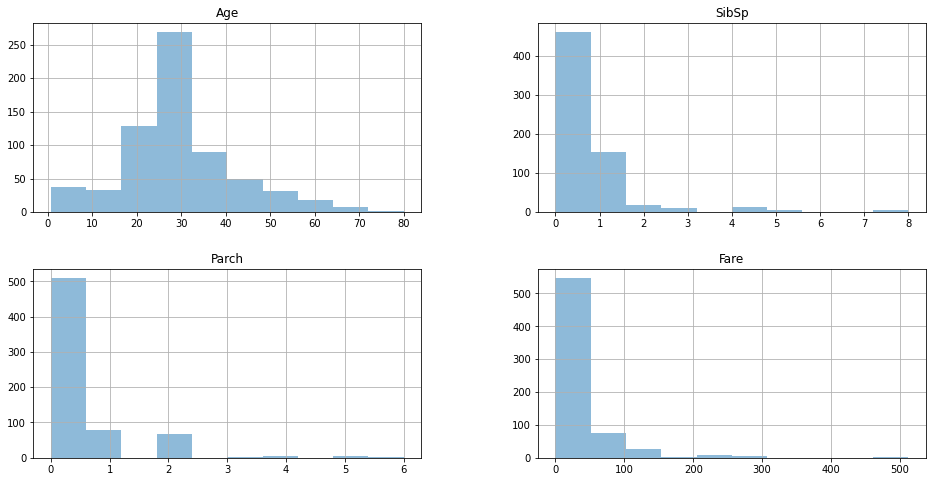

In [34]:
# histograms univariados
df_train.hist(figsize=(16, 8), alpha = 0.5)
plt.show()

Solamente la distribución de la edad parece tener una forma de campana compatible con la distribución normal, las demás son sesgadas a la izquierda.

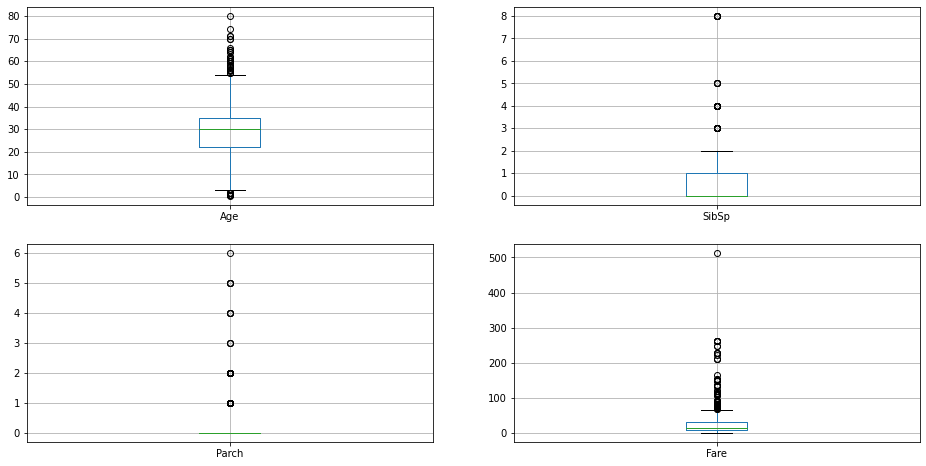

In [35]:
# boxplots
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
axs = ax.flatten()
for i in range(len(axs)):
  df_train._get_numeric_data().iloc[:,i].to_frame().boxplot(ax = axs[i])

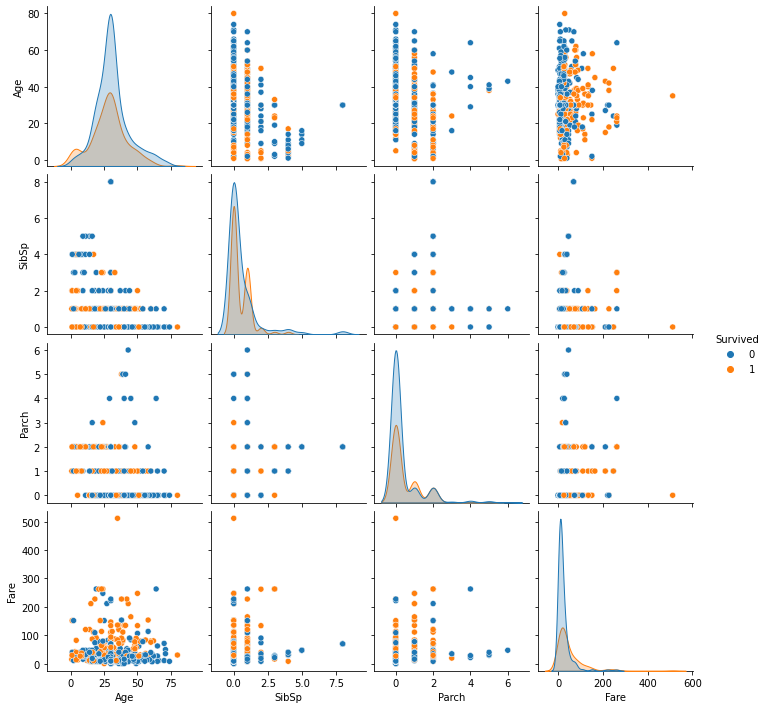

In [36]:
# análisis bivariado según categoría de variable target
sns.pairplot(data = df_train, hue = 'Survived')
plt.show()

Se observan algunas diferencias en las distribuciones de acuerdo a si sobrevivió o no. En particular la variable Fare (tarifa) parece ser una buena predictora de la supervivencia, y la variable Parch también.

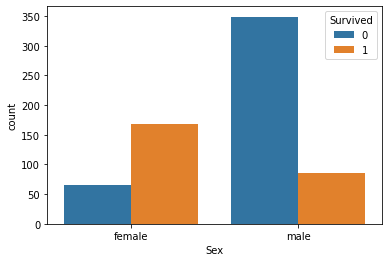

In [39]:
# análisis categórico bivariado: sex y survived
sns.countplot(data = df_train, x = 'Sex', hue = 'Survived')
plt.show()

En términos absolutos hay más hombres que mujeres, pero en términos de supervivencia hay más mujeres que hombres.

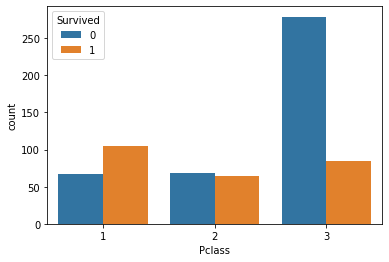

In [40]:
# análisis categórico bivariado: Pclass y survived
sns.countplot(data = df_train, x = 'Pclass', hue = 'Survived')
plt.show()

* La mayor proporción de supervivientes estaba en primera clase
* En primera clase hubo más supervivientes que no supervivientes, en segunda clase fue equilibrado, en tercera clase hubo más no supervivientes, casi 3 de cada 4 no sobrevivieron en esa clase

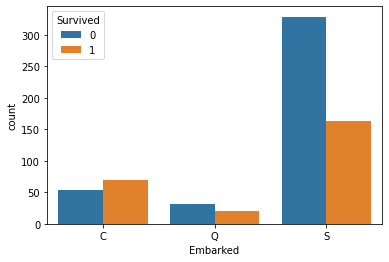

In [54]:
# análisis categórico bivariado: Embarked y survived
sns.countplot(data = df_train, x = 'Embarked', hue = 'Survived')
plt.show()

Los que embarcaron por "C" tuvieron una supervivencia superior (en proporción) a los que embarcaron en "S", la supervivencia en "Q" fue equitativa

<AxesSubplot:>

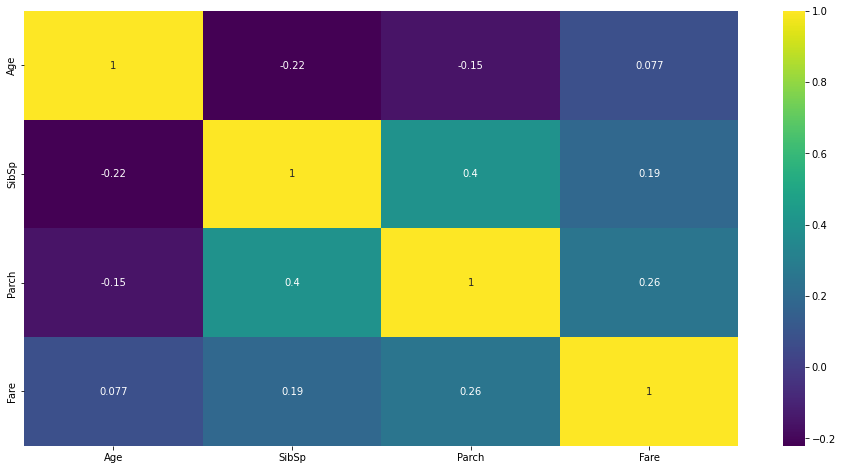

In [55]:
# correlaciones entre numéricas
plt.figure(figsize = (16, 8))
sns.heatmap(df_train.corr(), annot = True, cmap = 'viridis')

La correlación entre las variables numéricas es baja

In [68]:
# se elimina variable name del dataset, ya que no aporta
df_train = df_train.drop(columns = 'Name')

In [61]:
# se recodifica (en train y test) para que tome valores numéricos (siguen siendo categóricas)
df_train['Sex'] = df_train['Sex'].cat.codes
df_train['Embarked'] = df_train['Embarked'].cat.codes

In [62]:
# miro como quedó
df_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
PassengerId,,,,,,,,
810,1,0,33.000000,1,0,53.1000,2,1
2,1,0,38.000000,1,0,71.2833,0,1
126,3,1,12.000000,1,0,11.2417,0,1
561,3,1,29.946257,0,0,7.7500,1,0
34,2,1,66.000000,0,0,10.5000,2,0


In [63]:
# guardo dataset procesado
df_train.to_csv('../data/processed/datos_entrenamiento_procesados.csv', index = False)

In [72]:
# se vuelven a definir X_train e y_train para incorporar los ajustes
X_train = df_train.drop(columns = 'Survived')
y_train = df_train['Survived']

In [73]:
# elimino variables de X_test para que sea equivalente a X_train
X_test.drop(columns = ['Ticket', 'Name', 'Cabin'], inplace = True)

# recodifico categóricas
X_test['Sex'] = X_test['Sex'].cat.codes
X_test['Embarked'] = X_test['Embarked'].cat.codes

In [75]:
# reviso si hay null, porque la predicción da error en esos casos
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223 entries, 249 to 694
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Pclass    223 non-null    category
 1   Sex       223 non-null    int8    
 2   Age       193 non-null    float64 
 3   SibSp     223 non-null    int64   
 4   Parch     223 non-null    int64   
 5   Fare      223 non-null    float64 
 6   Embarked  223 non-null    int8    
dtypes: category(1), float64(2), int64(2), int8(2)
memory usage: 9.5 KB


Hay 30 valores nulos en edad, se eliminan para que no de error al predecir

In [87]:
# elimino observaciones con NA en alguna variable (sino da error al predecir)
df_test = pd.concat([X_test, y_test], axis = 1)
df_test.dropna(inplace = True)
X_test = df_test.drop(columns = 'Survived')
y_test = df_test['Survived']


## Step 3: Estimación modelo Random Forest

Primero se estima modelo con parámetros por defecto (sin tunear)

In [66]:
mod = RandomForestClassifier(random_state = 3007)
mod.fit(X_train, y_train)

RandomForestClassifier(random_state=3007)

In [104]:
# importancia de las variables
imp_mod = pd.DataFrame({'var':mod.feature_names_in_, 'imp': mod.feature_importances_}).sort_values(by = 'imp', ascending = False)
imp_mod

,var,imp
5,Fare,0.282474
2,Age,0.254717
1,Sex,0.238391
0,Pclass,0.100554
3,SibSp,0.045574
4,Parch,0.041960
6,Embarked,0.036330


Fare (tarifa), Age y Sex son las variables más importantes en este modelo. La menos importante es la puerta por donde embarcó el pasajero

In [89]:
# predicción con muestra test
y_pred = mod.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82       117
           1       0.73      0.71      0.72        76

    accuracy                           0.78       193
   macro avg       0.77      0.77      0.77       193
weighted avg       0.78      0.78      0.78       193



El modelo inicial tiene una precisión aceptable, predice mejor la clase mayoritaria. A continuación se busca qué combinación de hiperparámetros produce el mejor resultado (mayor precisión.)

Estos son los parámetros por defecto:
* n_estimators=100
* criterion=gini
* max_depthint=None
* min_samples_splitint=2
* min_samples_leafint=1
* min_weight_fraction_leaffloat=0.0
* max_features='sqrt'
* max_leaf_nodesint=None
* min_impurity_decreasefloat=0.0
* bootstrapbool=True
* oob_scorebool=False
* n_jobsint=None
* random_stateint=None
* verboseint=0
* warm_startbool=False
* class_weight=None
* ccp_alphanon=0.0
* max_samplesint=None


In [90]:
# Number of trees in random forest
n_estimators = [100, 300, 500]
# Maximum number of levels in tree
max_depth = [10, 50, 100, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
#Criterion
criterion=['gini','entropy']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap,
'criterion':criterion}
print(random_grid)

{'n_estimators': [100, 300, 500], 'max_depth': [10, 50, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']}


In [91]:
print('Cantidad máxima de combinaciones = ' + str(3*4*3*3*2*2))

Cantidad máxima de combinaciones = 432


In [94]:
# se aplica optimización aleatoria, es decir, elige algunas combinaciones al azar
mod_grid = RandomForestClassifier(random_state = 3007)
mod_grid_random = RandomizedSearchCV(estimator = mod_grid, n_iter = 100, cv = 5, random_state = 3007, param_distributions = random_grid)
mod_grid_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=3007),
                   n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 50, 100, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 300, 500]},
                   random_state=3007)

Mejor modelo (bosque):

In [95]:
best_param = mod_grid_random.best_params_
best_param

{'n_estimators': 300,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_depth': 10,
 'criterion': 'entropy',
 'bootstrap': False}

Estimo mejor modelo

In [96]:
# usando la mejor combinación de hiperparámetros, estimo modelo final
mod_best = RandomForestClassifier(**best_param)
mod_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=300)

In [102]:
# importancia de las variables
imp_best = pd.DataFrame({'var':mod_best.feature_names_in_, 'imp': mod_best.feature_importances_}).sort_values(by = 'imp', ascending = False)
imp_best

,var,imp
1,Sex,0.306313
5,Fare,0.246216
2,Age,0.199619
0,Pclass,0.129918
3,SibSp,0.044890
4,Parch,0.036694
6,Embarked,0.036349


Sero, Fare (Tarifa) y Edad son las variables más importantes en el modelo final. La menos importante es la puerta por donde embarcó

In [98]:
# predicción con muestra test
y_pred = mod_best.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       117
           1       0.80      0.72      0.76        76

    accuracy                           0.82       193
   macro avg       0.81      0.80      0.81       193
weighted avg       0.82      0.82      0.82       193



El nuevo modelo estimado mejora en accuracy tanto global como por categorías, mejora sustancialmente la categoría Survived = 1. La mejora ocurre en todos los indicadores

Guardo mejor modelo estimado

In [97]:
# se guarda modelo final
filename = '../models/finalized_model.sav'
pickle.dump(mod_best, open(filename, 'wb'))